# <p style="text-align: center;"> CSCE 633 Semester Project </p>
### <p style="text-align: center;"> Dylan Nguyen, 628002480 </p>

# Part (a) - Data Preprocessing

In [244]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split

In [262]:
"""
Function to:
1. remove stop words
2. create the sentiment labels
3. Sample a subset with an even distribution of sentiments
4. remove punctuation
5. convert to lowercase

Returns: dataframe containing preprocessed data
"""
def preprocess_and_sample(data_path, sample_size=None):
    df = pd.read_csv(data_path)
    stop_words = stopwords.words('english')

    # negative: 0, positive: 1, neutral, 2
    df['sentiment'] = df['stars'].apply(lambda x: 0 if x <= 2.0 else (1 if x > 3 else 2 ))
    
    df_sampled = df

    if sample_size:
        df_sampled, _ = train_test_split(df, test_size=1-sample_size, stratify=df['sentiment'], random_state=42)

    # removing stop words
    df_sampled['text'] = df_sampled['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    # removing punctuation and converting to lowercase
    df_sampled['text'] = df_sampled['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df_sampled['text'] = df_sampled['text'].str.lower()

    return df_sampled

# Part (b) - Input Data Preparation

In [246]:
from transformers import BertTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")

## Tokenizing and Producing Input IDs and Attention Mask Lists (due to padding with max length = 512)

In [247]:
# WordPiece tokenization function using BertTokenizer for correctly formatted input into Bert model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

"""
Tokenizes the input text and returns input IDs and attention mask
uses the global tokenizer to return matrices of input IDs and corresponding attention mask
"""
def prepare_data(df):
    # Tokenize and obtain input IDs and attention masks
    tokenized_texts = tokenizer.batch_encode_plus(
        df['text'].tolist(),
        add_special_tokens=True,
        max_length=192,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return tokenized_texts['input_ids'], tokenized_texts['attention_mask'], df['sentiment']

# Part (c) - Transformer Implementation

In [248]:
from transformers import BertModel
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [249]:
"""
Transformer Model for Sentiment Analysis
1. Bert is used to create contextual embeddings of shape (batch size, padding size, and hidden size (256 for bert mini)) given a vocabulary (input IDs) and attention mask
2. Dilated CNN is used to extract local features of each review
3. Pooling layer reduces the feature space while retaining essential feature information
4. Bi-LSTM is helps with contextual information (obtains both past and future context) and handles long dependencies
5. Dense layer outputs the logits of each class for every sample
"""
class SentimentTransformer(nn.Module):
    def __init__(self):
        super(SentimentTransformer, self).__init__()
        # Bert for creating textual embeddings
        self.bert = BertModel.from_pretrained('gaunernst/bert-mini-uncased')

        # Dilated convolution layers for semantic feature extraction in the large receptive field
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), dilation=1)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), dilation=2)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), dilation=3)

        # Activation layer using ReLU to prevent gradient vanishing
        self.relu = nn.ReLU()

        # max pooling layer with 2x2 filter size
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2))

        # Bi-LSTM layer with 128 units and 0.2% dropout rate
        self.bi_lstm = nn.LSTM(input_size=12000, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)

        # dense layer with 3 output neurons for predicting probabilities of classes belonging to sentiments
        self.dense = nn.Linear(in_features=256, out_features=3)


    def forward(self, input_ids, attention_mask):
        batch_size = input_ids.shape[0]
        # get contextual embeddings using the final output from the fully connected layer of BERT
        bert_output = self.bert(input_ids, attention_mask)
        embeddings = bert_output.last_hidden_state

        # adding a single channel dimension for feeding into convolution layers
        embeddings = embeddings.unsqueeze(dim=1)

        # Adaptive pooling to a common size
        target_size = (186, 250) 
        adaptive_pool = nn.AdaptiveAvgPool2d(target_size)

        # extract semantic features using dilated convolution layers with ReLU activation and resize each feature map
        feat_map1 = adaptive_pool(self.relu(self.conv1(embeddings)))
        feat_map2 = adaptive_pool(self.relu(self.conv2(embeddings)))
        feat_map3 = adaptive_pool(self.relu(self.conv3(embeddings)))

        # concatenate all feature maps into a single map
        combined_features = torch.cat((feat_map1, feat_map2, feat_map3), dim=1)
        
        # use max pooling to reduce the feature space
        pooled_features = self.max_pool(combined_features)

        # pooled features have shape: [batch_size, channels, height, width] 
        # reshape for LSTM by flattening width and channels into features, treat height as sequence length
        pooled_features = pooled_features.view(batch_size, 186, -1) 

        # pass through Bi-LSTM layer
        bi_lstm_output, _ = self.bi_lstm(pooled_features)

        # flatten bi lstm output to pass into dense layer
        bi_lstm_flattened = bi_lstm_output[:, -1, :]

        # dense layer with 3 outputs for predicting classification probabilities
        dense_output = self.dense(bi_lstm_flattened)
       
        
        return dense_output

# Part (d) - Model Training

## Preprocessing the Data and Creating Data Loaders

In [250]:
# Sampling 12% of the whole dataset which results in a subset of around 20000
data_path = './yelp_review_train.csv'
df = preprocess_and_sample(data_path, sample_size=0.09)
df

,text,stars,sentiment
90268,we saw celtic angels opening night clearwater ...,5.0,1
153492,the shadier place looks better donuts are that...,5.0,1
95123,the brisket sandwich excellent ill definitely ...,5.0,1
58834,for steak house burger chain every flight air ...,3.0,2
153249,ive coming months my favorite boba place my go...,5.0,1
...,...,...,...
121941,aweful customer service hour wait one letting ...,1.0,0
91801,in town short visit stumbled upon place great ...,5.0,1
65991,super excited try new place little bit letdown...,3.0,2
31948,this nice little uniform shop good selection p...,3.0,2


Mean Length: 71.5744532044761
Median Length: 52.0
Max Length: 712
95th Percentile Length: 190.0
99th Percentile Length: 330.0


In [251]:
# splitting into train and validation sets: ensures sentiment distribution is even in both
# validation set is 20% of the data
train_df, val_df = train_test_split(df, test_size=3145, stratify=df['sentiment'], random_state=42)

# Tokenizing the data and creating tensordatasets with the returned tensors
train_tokenized = prepare_data(train_df)
train_input_ids = train_tokenized[0].to(device)
train_attention_masks = train_tokenized[1].to(device)
train_sentiment = torch.tensor(train_tokenized[2].to_list()).to(device)

val_tokenized = prepare_data(val_df)
val_input_ids = val_tokenized[0].to(device)
val_attention_masks = val_tokenized[1].to(device)
val_sentiment = torch.tensor(val_tokenized[2].to_list()).to(device)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_sentiment)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_sentiment)

# Creating the dataloaders each with batch size 200
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150)

del train_tokenized, train_input_ids, train_attention_masks, train_sentiment, train_dataset, val_tokenized, val_input_ids, val_attention_masks, val_sentiment, val_dataset

## Training Loop

In [252]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [253]:
model = SentimentTransformer().to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# learning rate scheduler to decay the learning rate
scheduler = StepLR(optimizer, step_size=4, gamma=0.1) 

num_epochs = 6
best_val_accuracy = -1
training_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    losses = []
    for i, (input_ids_batch, attention_mask_batch, labels) in enumerate(train_loader):
        # forward pass in the model
        class_logits = model(input_ids_batch, attention_mask_batch)
        loss = loss_function(class_logits, labels)
        losses.append(loss)

        # backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute train accuracy
        predicted = torch.argmax(class_logits.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 20 == 0:
            print(f"Epoch [{epoch}], batch [{i}]: loss={loss}")
    
    train_accuracy = 100 * correct / total
    training_accuracies.append(train_accuracy)
    avg_loss = torch.mean(torch.stack(losses))

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_ids_batch, attention_mask_batch, labels in val_loader:
            # forward pass in the model
            class_logits = model(input_ids_batch, attention_mask_batch)
            predicted = torch.argmax(class_logits.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
    
    val_accuracy = 100 * correct / total
    validation_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    # update learning rate
    scheduler.step()

    print(f"Final results for epoch {epoch}:")
    print(f"average loss: {avg_loss}, train accuracy: {train_accuracy}, validation accuracy: {val_accuracy}")


Some weights of the model checkpoint at gaunernst/bert-mini-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch [0], batch [0]: loss=1.1084809303283691
Epoch [0], batch [20]: loss=0.9216156005859375
Epoch [0], batch [40]: loss=0.8375244140625
Epoch [0], batch [60]: loss=0.7822162508964539
Epoch [0], batch [80]: loss=0.8064051866531372
Epoch [0], batch [100]: loss=0.8306277394294739
Epoch [0], batch [120]: loss=0.8187606930732727
Final results for epoch 0:
average loss: 0.8859952688217163, train accuracy: 66.23221807200191, validation accuracy: 67.05882352941177
Epoch [1], batch [0]: loss=0.7505002617835999
Epoch [1], batch [20]: loss=0.8537611365318298
Epoch [1], batch [40]: loss=0.8557521104812622
Epoch [1], batch [60]: loss=0.9411726593971252
Epoch [1], batch [80]: loss=0.8009128570556641
Epoch [1], batch [100]: loss=0.8803435564041138
Epoch [1], batch [120]: loss=0.8826737999916077
Final results for epoch 1:
average loss: 0.8220421671867371, train accuracy: 67.05078280219344, validation accuracy: 67.05882352941177
Epoch [2], batch [0]: loss=0.8121992349624634
Epoch [2], batch [20]: loss

## Plot Training Data

In [257]:
temp_train_accuracies = training_accuracies
temp_val_accuracies = validation_accuracies
print(temp_train_accuracies)
print(temp_val_accuracies)

[66.23221807200191, 67.05078280219344, 67.06667726297385, 72.34363824207264, 79.98887387745371, 80.39418262735437]
[67.05882352941177, 67.05882352941177, 67.05882352941177, 80.15898251192368, 80.60413354531002, 81.04928457869634]


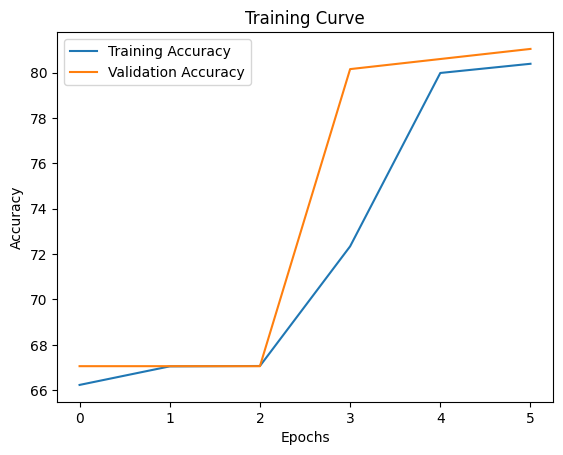

In [254]:
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


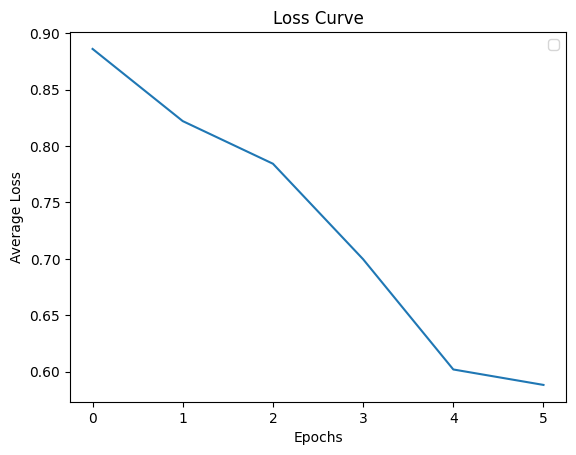

In [281]:
# loss vs epochs
plt.plot(range(6), [0.8859952688217163, 0.8220421671867371, 0.784285306930542, 0.69968181848526, 0.6020187139511108, 0.5883263945579529],)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

## Further Tuning of Model

In [278]:
# Load the best saved model
best_model_path = 'best_model.pth' 
model.load_state_dict(torch.load(best_model_path))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# learning rate scheduler to decay the learning rate
scheduler = StepLR(optimizer, step_size=2, gamma=0.1) 

# Initialize the early stopping patience and the counter
patience = 2  # Number of epochs to wait after last time validation loss improved
patience_counter = 0  # Counter for how many epochs have gone by since last improvement

num_epochs = 4

best_val_accuracy = -float('inf')
training_accuracies = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    losses = []
    for i, (input_ids_batch, attention_mask_batch, labels) in enumerate(train_loader):
        # forward pass in the model
        class_logits = model(input_ids_batch, attention_mask_batch)
        loss = loss_function(class_logits, labels)
        losses.append(loss)

        # backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute train accuracy
        predicted = torch.argmax(class_logits.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 20 == 0:
            print(f"Epoch [{epoch}], batch [{i}]: loss={loss}")
    
    train_accuracy = 100 * correct / total
    training_accuracies.append(train_accuracy)
    avg_loss = torch.mean(torch.stack(losses))

    # validation
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    with torch.no_grad():
        for input_ids_batch, attention_mask_batch, labels in val_loader:
            # forward pass in the model
            class_logits = model(input_ids_batch, attention_mask_batch)
            predicted = torch.argmax(class_logits.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
    
    val_accuracy = 100 * correct / total
    validation_accuracies.append(val_accuracy)

    # Calculate average validation loss
    avg_val_loss = torch.mean(torch.tensor(val_losses))

    # Check for early stopping using accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0  # Reset the patience counter
        # Save the new best model based on accuracy
        torch.save(model.state_dict(), 'best_model_updated.pth')
    else:
        patience_counter += 1  # Increment the patience counter

    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch} due to no improvement in validation accuracy.")
        break

    # update learning rate
    scheduler.step()

    print(f"Final results for epoch {epoch}:")
    print(f"average loss: {avg_loss}, train accuracy: {train_accuracy}, validation accuracy: {val_accuracy}")

Epoch [0], batch [0]: loss=0.5577850341796875
Epoch [0], batch [20]: loss=0.62264084815979
Epoch [0], batch [40]: loss=0.4268188774585724
Epoch [0], batch [60]: loss=0.5700986981391907
Epoch [0], batch [80]: loss=0.5683433413505554
Epoch [0], batch [100]: loss=0.5170037150382996
Epoch [0], batch [120]: loss=0.60487961769104
Final results for epoch 0:
average loss: 0.5731772184371948, train accuracy: 81.07764444091234, validation accuracy: 81.46263910969793
Epoch [1], batch [0]: loss=0.6055797338485718
Epoch [1], batch [20]: loss=0.624616801738739
Epoch [1], batch [40]: loss=0.519636332988739
Epoch [1], batch [60]: loss=0.6026710867881775
Epoch [1], batch [80]: loss=0.5729271173477173
Epoch [1], batch [100]: loss=0.5332537889480591
Epoch [1], batch [120]: loss=0.5847166180610657
Final results for epoch 1:
average loss: 0.5617592334747314, train accuracy: 81.26043073988716, validation accuracy: 81.39904610492846
Epoch [2], batch [0]: loss=0.5705747008323669
Epoch [2], batch [20]: loss=0.

KeyboardInterrupt: 

# Part(e) - Result Analysis

## Preprocessing Similar to the Train Set

In [265]:
test_data_path = './yelp_review_test.csv'
df_test = preprocess_and_sample(test_data_path)

In [268]:
# tokenization
test_tokenized = prepare_data(df_test)
test_input_ids = test_tokenized[0].to(device)
test_attention_mask = test_tokenized[1].to(device)
test_sentiments = torch.tensor(test_tokenized[2].to_list())

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_sentiments)
test_loader = DataLoader(test_dataset, batch_size=100)

## Testing Loop

In [270]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

In [273]:
best_model_path = 'best_model.pth'
best_model = SentimentTransformer().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))

best_model.eval()
test_accuracy = 0
total = 0
true_labels = []
predictions = []
num_classes = 3

with torch.no_grad():
    for i, (input_ids_batch, attention_mask_batch, labels) in enumerate(test_loader):
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        labels = labels.to(device)

        # Get the raw class scores
        class_logits = model(input_ids_batch, attention_mask_batch)
        predicted = torch.argmax(class_logits, dim=1)
        
        # Store predictions and true labels
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        # update total accuracy
        total += labels.size(0)
        test_accuracy += (predicted == labels).sum().item()

        if i % 20 == 0:
            curr_accuracy = 100 * test_accuracy / total
            print(f"Batch [{i}], current accuracy = {curr_accuracy}")


Some weights of the model checkpoint at gaunernst/bert-mini-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batch [0], current accuracy = 78.0
Batch [20], current accuracy = 80.71428571428571
Batch [40], current accuracy = 81.21951219512195
Batch [60], current accuracy = 81.04918032786885
Batch [80], current accuracy = 80.87654320987654
Batch [100], current accuracy = 80.67326732673267
Batch [120], current accuracy = 80.6694214876033


In [274]:

# Binarize the labels for multiclass ROC AUC
true_labels_binary = label_binarize(true_labels, classes=range(num_classes))

# calculate f1 score, accuracy, recall, precision, AUC
test_accuracy = test_accuracy / total * 100
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
roc_auc = roc_auc_score(true_labels_binary, label_binarize(predictions, classes=range(num_classes)), multi_class='ovr')

print(f"Test accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")

Test accuracy: 80.80114449213161
Precision: 0.7261571610463617
Recall: 0.8080114449213162
F1 Score: 0.7649006595697603
AUC: 0.7107008757353391


/Users/dylannguyen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Analysis

Overall, I received very decent results. Many training epochs were not needed due to the trained parameters of BERT mini. However, this model is very robust and can perform much better with a lot more hyperparameter tuning. First, hyperparameters such as batch size, learning rate, and epochs can be further experimented and optimized to ensure optimal convergence. Next, the experimentation of more encoder and attention layers can even better contextual representations. It was not feaasible to tune this layers as BERT is computationally expensive which means that I could not explore with other BERT variations with more layers. The additional encoder and multi-head layers can further learn the contexts and semantics around each piece of text, ultimately resulting in better representations of the context. Regardless, this model did perform well given the computational hardships and complexity.